# Variance inflation factor (VIF) and explainability

In [1]:
from pathlib import Path
from tempfile import gettempdir

import kaggle.api as kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data

In [2]:
data_path = Path(gettempdir()) / "gagandeep16/car-sales" / "Car_sales.csv"

kaggle.authenticate()
kaggle.dataset_download_files("gagandeep16/car-sales", data_path.parent, unzip=True)

df = pd.read_csv(data_path)
# df['year'] = pd.to_datetime(df.Latest_Launch).dt.year

# df = df.drop(['__year_resale_value', 'Latest_Launch'], axis=1)
# df.dropna(inplace=True)
df.fillna(0, inplace=True)
df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,0.00,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,0.000000
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         157 non-null    object 
 1   Model                157 non-null    object 
 2   Sales_in_thousands   157 non-null    float64
 3   __year_resale_value  157 non-null    float64
 4   Vehicle_type         157 non-null    object 
 5   Price_in_thousands   157 non-null    float64
 6   Engine_size          157 non-null    float64
 7   Horsepower           157 non-null    float64
 8   Wheelbase            157 non-null    float64
 9   Width                157 non-null    float64
 10  Length               157 non-null    float64
 11  Curb_weight          157 non-null    float64
 12  Fuel_capacity        157 non-null    float64
 13  Fuel_efficiency      157 non-null    float64
 14  Latest_Launch        157 non-null    object 
 15  Power_perf_factor    157 non-null    flo

# EDA

## Heatmap
매우 강한 상관관계를 보이는 요소들

- `Power_perf_factor` and `Horsepower`
- `Fuel_efficiency` and `Engine_size`
- `Fuel_efficiency` and `Curb_weight`
- `Fuel_efficiency` and `Fuel_capacity`.

/tmp/ipykernel_18940/3242547526.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df.corr(), dtype=bool))
/tmp/ipykernel_18940/3242547526.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)


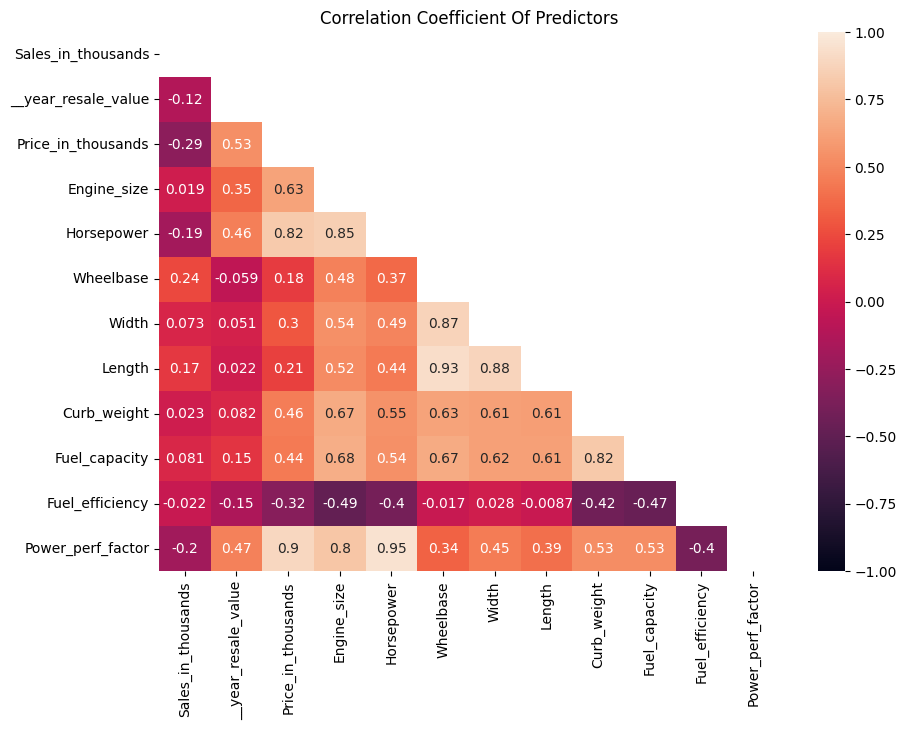

In [4]:
# set figure size
plt.figure(figsize=(10, 7))

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title("Correlation Coefficient Of Predictors")
plt.show()

# VIF

- 대충 5이상이면 큰 편으로 취급 가능

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# compute the vif for all given features
def compute_vif(considered_features):
    x_df = df[considered_features]
    # the calculation of variance inflation requires a constant
    x_df["intercept"] = 1

    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = x_df.columns
    vif["VIF"] = [
        variance_inflation_factor(x_df.values, i) for i in range(x_df.shape[1])
    ]
    vif = vif[vif["Variable"] != "intercept"]
    return vif

In [6]:
# features to consider removing
considered_features = [
    "Fuel_efficiency",
    "Power_perf_factor",
    "Engine_size",
    "Horsepower",
    "Fuel_capacity",
    "Curb_weight",
]

# compute vif
compute_vif(considered_features).sort_values("VIF", ascending=False)

/tmp/ipykernel_18940/3733960371.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df["intercept"] = 1


,Variable,VIF
3,Horsepower,13.592581
1,Power_perf_factor,10.779275
2,Engine_size,5.002690
4,Fuel_capacity,3.443331
5,Curb_weight,3.211638
0,Fuel_efficiency,1.375416


In [7]:
considered_features.remove("Horsepower")
# considered_features.remove('Power_perf_factor')
compute_vif(considered_features).sort_values("VIF", ascending=False)

/tmp/ipykernel_18940/3733960371.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df["intercept"] = 1


,Variable,VIF
2,Engine_size,4.071470
3,Fuel_capacity,3.420091
4,Curb_weight,3.210767
1,Power_perf_factor,2.826887
0,Fuel_efficiency,1.372914


# Model

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from eli5 import show_prediction, show_weights

In [9]:
# Category -> one-hot encoding
category_columns = [var for var in df.columns if df[var].dtypes == "object"]
one_hots = pd.get_dummies(df[category_columns])

# No removed features
df1 = pd.concat([df, one_hots], axis=1)
df1 = df1.drop(category_columns, axis=1)

# High VIF removed features
df2 = df.drop(["Horsepower"], axis=1)
df2 = pd.concat([df2, one_hots], axis=1)
df2 = df2.drop(category_columns, axis=1)

In [10]:
def build_train_test(data, y):
    # Trian & Test Dataset
    x_data = data.drop(y, axis=1)
    y_data = data["Price_in_thousands"]
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=0.25, random_state=0
    )

    mms = MinMaxScaler()
    x_train = mms.fit_transform(x_train)
    x_test = mms.transform(x_test)
    
    x_train = pd.DataFrame(x_train, columns=x_data.columns)
    x_test = pd.DataFrame(x_test, columns=x_data.columns)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = build_train_test(df1, y='Price_in_thousands')
    
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

# compute mean_squared errors for both models
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('R^2:', r2)

show_weights(lr, top=30, feature_names=x_train.columns.tolist())

MSE: 34.08010010103825
R^2: 0.8316893369966416


Weight?,Feature
+21.811,Power_perf_factor
+16.004,Horsepower
+15.937,Manufacturer_Mercedes-B
+15.088,Model_CL500
+12.525,<BIAS>
+10.914,Manufacturer_Porsche
+9.877,Engine_size
+8.850,__year_resale_value
+8.421,Latest_Launch_4/11/2011
+8.101,Model_LX470


In [11]:
x_train, x_test, y_train, y_test = build_train_test(df2, y='Price_in_thousands')

lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

# compute mean_squared errors for both models
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('R^2:', r2)

show_weights(lr, top=30, feature_names=x_train.columns.tolist())

MSE: 35.65227958713022
R^2: 0.823924847723432


Weight?,Feature
+26.493,Power_perf_factor
+16.942,Manufacturer_Mercedes-B
+15.889,Model_CL500
+13.654,Engine_size
+11.871,Manufacturer_Porsche
+11.466,<BIAS>
+10.985,__year_resale_value
+8.736,Model_C70
+8.724,Latest_Launch_4/11/2011
+8.167,Model_Carrera Cabrio


# Feature Analysis